# Denoising Challenge

In [14]:
import  torch
torch.__version__

'0.4.0'

### Importing & prepare data

In [24]:
import numpy as np

with np.load('./data/denoising-challenge-01-data.npz') as fh:
        train_y = fh['training_images_clean']
        validation_x = fh['validation_images_noisy']
        validation_y = fh['validation_images_clean']
        test_x = fh['test_images_noisy']

### Data shapes

In [25]:
print('training: ' + str(train_y.shape))
print('validation: ' + str(validation_x.shape))
print('test: ' + str(test_x.shape))

training: (20000, 1, 28, 28)
validation: (2000, 1, 28, 28)
test: (2000, 1, 28, 28)


### Visualize some data

(1, 28, 28)


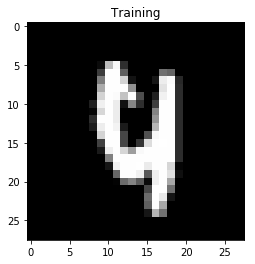

In [26]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure()
plt.title('Training')
print(train_y[0].shape)
plt.imshow(train_y[0].reshape(28,28), cmap='gray')

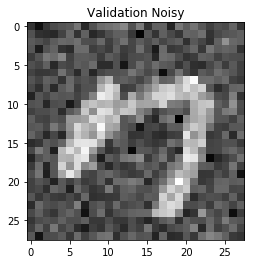

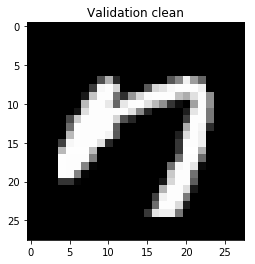

In [27]:
plt.figure()
plt.title('Validation Noisy')
plt.imshow(validation_x[0].reshape(28,28), cmap='gray')

plt.figure()
plt.title('Validation clean')
plt.imshow(validation_y[0].reshape(28,28), cmap='gray')

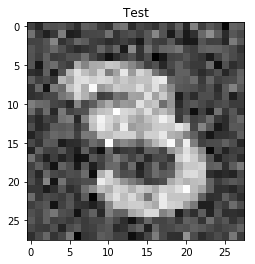

In [28]:
plt.figure()
plt.title('Test')
plt.imshow(test_x[0].reshape(28,28), cmap='gray')

### Calculate standart deviation of gaussian noise

In [29]:
noise = validation_x - validation_y
noise_sigma = np.std(noise)

noise_sigma

0.20003203

### Create a noise generator

In [30]:
def getNoisy(clean, sigma=noise_sigma):
    return clean + sigma * np.random.normal(0, 1, clean.shape)

### Check if we get everything right by adding noise to validation image and displaying it

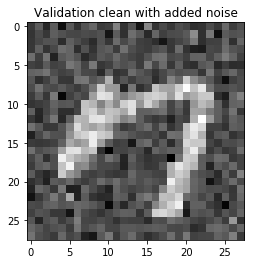

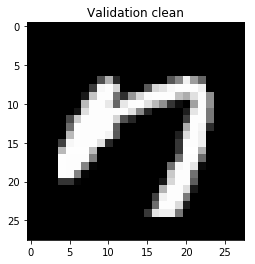

In [43]:
plt.figure()
plt.title('Validation clean with added noise')
plt.imshow(getNoisy(validation_y[0]).reshape(28, 28), cmap='gray')

plt.figure()
plt.title('Validation clean')
plt.imshow(validation_y[0].reshape(28,28), cmap='gray')

### Data Augmentation (Bootstrapping)

We don't really want to predict anything so we can go wild and crazy with the transformations (horizontal & vertical flips, random rotations, etc.). As we don't have much computing power however, we will only use flips, as they are pretty fast to compute.

In [45]:
def horizontalFlip(image):
    return np.flip(image, 3)

def verticalFlip(image):
    return np.flip(image, 2)

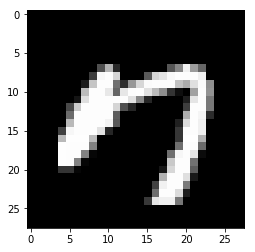

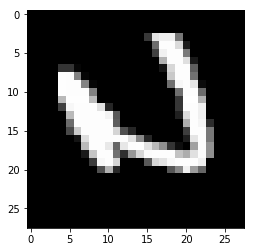

In [44]:
plt.figure("some image")
plt.imshow(validation_y[0].reshape(28,28), cmap='gray')

plt.figure("some vertically flipped image")
plt.imshow(verticalFlip(validation_y)[0].reshape(28,28), cmap='gray')

In [137]:
def get_train_x(train_y):
    # with 20% probability, flip in each direction
    flip_x = np.where(np.random.binomial(1, 0.2, size=len(train_y)) == 1)[0]
    flip_y = np.where(np.random.binomial(1, 0.2, size=len(train_y)) == 1)[0]
    train_x = getNoisy(train_y)
    train_x[flip_x] = horizontalFlip(train_x[flip_x])
    train_x[flip_y] = horizontalFlip(train_x[flip_y])
    
    return train_x

### Prepare data for training

In [138]:
import torch.utils.data as data_utils

kwargs  =  {'num_workers': 1, 'pin_memory': True} if torch.cuda.is_available() else {'num_workers': 16}

train_dataset = data_utils.TensorDataset(torch.from_numpy(train_y), torch.from_numpy(train_y))
validation_dataset = data_utils.TensorDataset(torch.from_numpy(validation_x), torch.from_numpy(validation_y))

train_loader = torch.utils.data.DataLoader(train_dataset,
                                           batch_size=128, 
                                           shuffle=True,
                                           **kwargs)
validation_loader = torch.utils.data.DataLoader(validation_dataset,
                                          batch_size=128,
                                          shuffle=False,
                                          **kwargs)

torch.Size([128, 1, 28, 28])


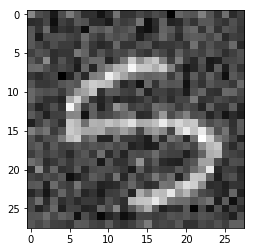

In [139]:
for batch_idx, (data, target) in enumerate(train_loader):
    print(data.shape)
    augmented_data = torch.from_numpy(get_train_x(data.numpy()))
    plt.imshow(augmented_data[0].reshape(28,28), cmap="gray")
    break

## Model

We based our model entirely on residual denoising convolutional NN. Further information can be found in this paper (https://arxiv.org/pdf/1608.03981.pdf). 

In [142]:
import torch.nn as nn
import torch.nn.functional as F

NUM_TYPE_2_LAYERS = 14

class VGG(nn.Module):
    def __init__(self):
        super(VGG, self).__init__()
        self.layers = self._make_layers()

    def forward(self, x):
        return self.layers(x)
    
    def _make_layers(self):
        conv_layers = []
        
        conv_layers += [
            nn.Conv2d(1, 64, kernel_size=3, padding=1),
            # NOTE: no BN here
            nn.ReLU(inplace=True)
        ]
        for i in range(NUM_TYPE_2_LAYERS):
            conv = nn.Conv2d(64, 64, kernel_size=3, padding=1)
            conv_layers += [conv,
                           nn.BatchNorm2d(64),
                           nn.ReLU(inplace=True)]
            
        conv_layers += [
            # NOTE: only one mask is produced here, the residual image
            nn.Conv2d(64, 1, kernel_size=3, padding=1),
            # NOTE: no BN here
            nn.ReLU(inplace=True)
        ]
            
        return nn.Sequential(*conv_layers)

In [143]:
model = VGG()
if torch.cuda.is_available():
    model.cuda()

In [144]:
import torch.optim as optim

optimizer = optim.Adam(model.parameters(), lr=0.01)

In [145]:
from torch.autograd import Variable

def train(epoch, callback):
    model.train()
    
    for batch_idx, (data, target) in enumerate(train_loader):
        if torch.cuda.is_available():
            data, target = data.cuda(), target.cuda()
        augmented_data = torch.from_numpy(get_train_x(data.numpy()))
        data, target = Variable(augmented_data), Variable(target)

        optimizer.zero_grad()
        output = model(data)
        
        loss = F.mse_loss(data - output, target)
        loss.backward()
        
        optimizer.step()
        
        callback(batch_idx, output, target)
        
        print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, (batch_idx + 1) * len(data), len(train_loader.dataset),
                100. * (batch_idx + 1) / len(train_loader), loss.data[0]))

In [ ]:
def test():
    model.eval()
    
    test_loss = 0
    correct = 0
    for data, target in validation_loader:
        if torch.cuda.is_available():
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)
        
        output = model(data)
        test_loss += F.mse_loss(data - output, target, size_average=False).item()[0] # sum up batch loss
        
        
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.3f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    return 100. * correct / len(test_loader.dataset), test_loss